# ABHIRAJ SINGH HW-2 (CIS 731) 

DATASET DESCRIPTION: https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset#

In [65]:
#import the libraries required for the tasks
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.callbacks import History
from collections import Iterable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler

In [33]:
#to load and run the dataset locally
 
df = pd.read_csv('london_merged.csv',header=0, parse_dates=['timestamp'],index_col='timestamp')
print(df.shape)
df.head(5)

(17414, 9)


,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


# Data processinng and transformation

In [34]:

df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

print(df.shape)
df.head()

(17414, 13)


,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_month,day_of_week,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,4,6,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,4,6,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,4,6,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,4,6,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,4,6,1


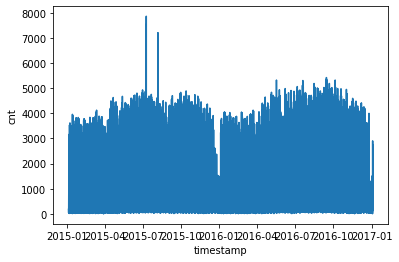

In [35]:
sns.lineplot(x=df.index, y=df.cnt,data=df)

In [36]:
df_by_hour = df.resample('h').sum()

In [37]:
train_size = int(len(df)*0.8)
test_size = len(df) - train_size

train = df.iloc[0:train_size]
test = df.iloc[train_size:len(df)]

print(train.shape)
print(test.shape)

(13931, 13)
(3483, 13)


In [38]:
df.shape

(17414, 13)

# Normalization of the dataset

In [39]:
f_columns = ['t1', 't2', 'hum', 'wind_speed']

f_transformer = MinMaxScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())

cnt_transformer = MinMaxScaler()
cnt_transformer = cnt_transformer.fit(train[['cnt']])
train['cnt'] = cnt_transformer.transform(train[['cnt']])
test['cnt'] = cnt_transformer.transform(test[['cnt']])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [40]:
#create subset of the dataset for the time series analysis

def dataset(x,y,time_steps=1):
  xs, ys = [], []
  for i in range(len(x) - time_steps):
    v = x.iloc[i : (i+time_steps)].to_numpy()
    xs.append(v)
    ys.append(y.iloc[i+time_steps])
  return np.array(xs), np.array(ys)


In [41]:
TIME_STEPS = 24

x_train, y_train = dataset(train, train.cnt, time_steps = TIME_STEPS)
x_test, y_test = dataset(test, test.cnt, time_steps = TIME_STEPS)

In [42]:
#samples, timesteps, features
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(13907, 24, 13) (13907,)
(3459, 24, 13) (3459,)


In [43]:
#create a timehistory class to get a time for building a network
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

# LSTM

In [47]:

%%time

np.random.seed = 2   #2, 42
tf.random.set_seed = 1  #42
time_callback = TimeHistory()

history = History()

model = Sequential()
model.add(keras.layers.LSTM(units = 1, input_shape = (x_train.shape[1],x_train.shape[2])))
model.add(keras.layers.Dense(units = 1))

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(
    x_train,y_train, 
    epochs= 40,
    shuffle = False,
    batch_size = 100,
    callbacks=[history,time_callback],
    validation_split = 0.3,
    verbose = 0
)


CPU times: user 54.8 s, sys: 4.13 s, total: 58.9 s
Wall time: 35.3 s


In [48]:
print(model.summary())
train_mse_lstm = history.history.get('loss')
val_mse_lstm = history.history.get('val_loss')
time_lstm = list(time_callback.times)
print('Total time taken ',sum(time_lstm))
print(train_mse_lstm)
print(val_mse_lstm)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1)                 60        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 2         
Total params: 62
Trainable params: 62
Non-trainable params: 0
_________________________________________________________________
None
Total time taken  34.91454195976257
[0.02676546759903431, 0.019039008766412735, 0.01794806495308876, 0.017883341759443283, 0.017895735800266266, 0.017908599227666855, 0.01791686937212944, 0.016575515270233154, 0.015020252205431461, 0.014423444867134094, 0.014140092767775059, 0.013960091397166252, 0.013821114785969257, 0.013712750747799873, 0.013629574328660965, 0.013565605506300926, 0.013514789752662182, 0.013472328893840313, 0.013435572385787964, 0.013403864577412605, 0.013376077637076378, 0.01335083693265915

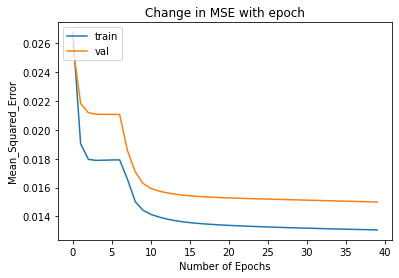

In [49]:
plt.plot(train_mse_lstm)
plt.plot(val_mse_lstm)
plt.xlabel('Number of Epochs')
plt.ylabel('Mean_Squared_Error')
plt.title('Change in MSE with epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

# GRU

In [16]:

%%time

np.random.seed = 2   #2, 42
#tf.random.set_seed = 20  #42
time_callback = TimeHistory()

history = History()

model = Sequential()
model.add(keras.layers.GRU(units = 2, input_shape = (x_train.shape[1],x_train.shape[2])))
model.add(keras.layers.Dense(units = 1))

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(
    x_train,y_train, 
    epochs= 40,
    shuffle = False,
    batch_size = 100,
    callbacks=[history,time_callback],
    validation_split = 0.3,
    verbose = 0
)


CPU times: user 1min 3s, sys: 4.97 s, total: 1min 8s
Wall time: 40.4 s


In [17]:
print(model.summary())
train_mse_gru = history.history.get('loss')
val_mse_gru = history.history.get('val_loss')
time_gru = list(time_callback.times)
print('Total time taken ',sum(time_gru))
print(train_mse_gru)
print(val_mse_gru)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 2)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________
None
Total time taken  40.12929916381836
[2.477804660797119, 0.685613214969635, 0.2923751175403595, 0.10837174206972122, 0.06572099030017853, 0.0508919321000576, 0.039854228496551514, 0.03286776319146156, 0.02799188904464245, 0.024456173181533813, 0.02212998829782009, 0.020667366683483124, 0.019734125584363937, 0.019121915102005005, 0.018708745017647743, 0.01842232421040535, 0.018218841403722763, 0.018071036785840988, 0.0179615281522274, 0.017878973856568336, 0.0178158488124609, 0.01776694320142269, 0.01772867701

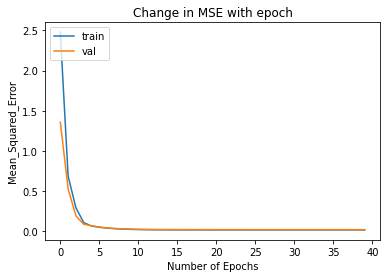

In [18]:
plt.plot(train_mse_gru)
plt.plot(val_mse_gru)
plt.xlabel('Number of Epochs')
plt.ylabel('Mean_Squared_Error')
plt.title('Change in MSE with epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

# Back Propogation Through Time (BPTT)

In [51]:

%%time

np.random.seed = 2   #2, 42
#tf.random.set_seed = 20  #42
time_callback = TimeHistory()

history = History()

model = Sequential()
model.add(SimpleRNN(units=1, input_shape=(x_train.shape[1],x_train.shape[2]),activation='sigmoid'))
model.add(keras.layers.Dense(units = 1))

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(
    x_train,y_train, 
    epochs= 40,
    shuffle = False,
    batch_size = 100,
    callbacks=[history,time_callback],
    validation_split = 0.3,
    verbose = 0
)


CPU times: user 25.4 s, sys: 2.3 s, total: 27.7 s
Wall time: 17.2 s


In [52]:
print(model.summary())
train_mse_rnn = history.history.get('loss')
val_mse_rnn = history.history.get('val_loss')
time_rnn = list(time_callback.times)
print('Total time taken ',sum(time_rnn))
print(train_mse_rnn)
print(val_mse_rnn)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 1)                 15        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________
None
Total time taken  17.040717363357544
[0.5175532698631287, 0.25247061252593994, 0.13943880796432495, 0.08806751668453217, 0.06208940967917442, 0.04730076715350151, 0.038128066807985306, 0.03231046721339226, 0.028571607545018196, 0.026105735450983047, 0.02442276105284691, 0.02322986349463463, 0.02234991453588009, 0.021671608090400696, 0.021122436970472336, 0.020655417814850807, 0.020243139937520027, 0.019873877987265587, 0.019545190036296844, 0.019255300983786583, 0.018998868763446808, 0.018769551068544388, 0.01

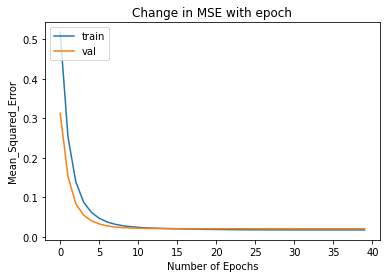

In [53]:
plt.plot(train_mse_rnn)
plt.plot(val_mse_rnn)
plt.xlabel('Number of Epochs')
plt.ylabel('Mean_Squared_Error')
plt.title('Change in MSE with epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

# FeedForward Neural Network

In [22]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_month,day_of_week,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,0.126761,0.2000,0.911950,0.106195,3.0,0.0,1.0,3.0,0,4,6,1
2015-01-04 01:00:00,138,0.126761,0.2125,0.911950,0.088496,1.0,0.0,1.0,3.0,1,4,6,1
2015-01-04 02:00:00,134,0.112676,0.2125,0.955975,0.000000,1.0,0.0,1.0,3.0,2,4,6,1
2015-01-04 03:00:00,72,0.098592,0.2000,1.000000,0.000000,1.0,0.0,1.0,3.0,3,4,6,1
2015-01-04 04:00:00,47,0.098592,0.1500,0.911950,0.115044,1.0,0.0,1.0,3.0,4,4,6,1


In [23]:
#Splitting into X and Y i.e. input and output variables respectively
x_ff = df.loc[:,'t1':'month']
y_ff = df.loc[:,'cnt']

In [24]:
type(np.array(y_ff))

numpy.ndarray

In [25]:
minmax = MinMaxScaler()

x = minmax.fit_transform(x_ff)

# transform target variables
y = minmax.fit_transform(np.array(y_ff).reshape(-1,1))

In [26]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.30, random_state=8)

In [27]:
#create a d-2d-1 neural network with sigmoid activation function
%%time

time_callback = TimeHistory()

history = History()

model2 = Sequential()
model2.add(Dense(24, input_dim = 12, activation = 'sigmoid'))
model2.add(Dense(1))

model2.compile(loss='mean_squared_error', optimizer='sgd')

model2.fit(x_train, y_train, batch_size=12189, epochs=40, verbose=0, callbacks=[history,time_callback],validation_data=(x_val,y_val))

CPU times: user 1.21 s, sys: 40.4 ms, total: 1.25 s
Wall time: 1.12 s


In [28]:
print(model2.summary())
train_ff = history.history.get('loss')
val_ff = history.history.get('val_loss')
time_ff = list(time_callback.times)
print('Total time taken ',sum(time_ff))
print(train_ff)
print(val_ff)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 24)                312       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25        
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________
None
Total time taken  1.0211539268493652
[0.21328595280647278, 0.16217990219593048, 0.12498781830072403, 0.09791363030672073, 0.07819990068674088, 0.06384242326021194, 0.05338359251618385, 0.04576308652758598, 0.04020917788147926, 0.0361601747572422, 0.03320714458823204, 0.031052350997924805, 0.029478944838047028, 0.02832903526723385, 0.027487607672810555, 0.02687090076506138, 0.026417899876832962, 0.026084143668413162, 0.025837285444140434, 0.025653725489974022, 0.025516286492347717, 0.02541245147585869, 0.0253

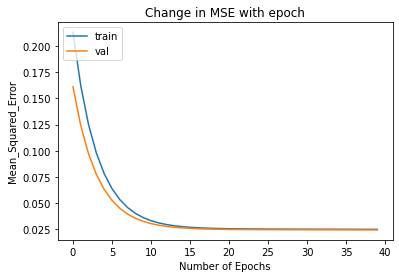

In [29]:
plt.plot(train_ff)
plt.plot(val_ff)
plt.xlabel('Number of Epochs')
plt.ylabel('Mean_Squared_Error')
plt.title('Change in MSE with epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

# Model Comparision 

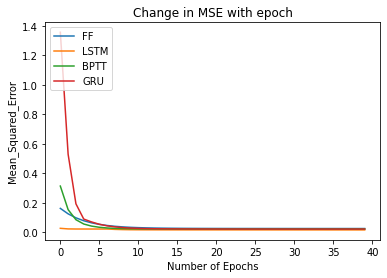

In [62]:
#plot the mse for the FF, BPTT, RNN, GRU
plt.plot(val_ff)
plt.plot(val_mse_lstm)
plt.plot(val_mse_rnn)
plt.plot(val_mse_gru)
plt.xlabel('Number of Epochs')
plt.ylabel('Mean_Squared_Error')
plt.title('Change in MSE with epoch')
plt.legend(['FF','LSTM','BPTT','GRU'],loc='upper left')
plt.show()

In [63]:
#Dataframe for MSE and Total_Time
d = {'MSE': [val_ff[-1], val_mse_lstm[-1], val_mse_rnn[-1], val_mse_gru[-1]], 'Total_Time': [sum(time_ff), sum(time_lstm), sum(time_rnn), sum(time_gru)]}
result_df = pd.DataFrame(data=d, index=['FF','LSTM','BPTT','GRU'])
result_df

,MSE,Total_Time
FF,0.024377,1.021154
LSTM,0.014993,34.914542
BPTT,0.021005,17.040717
GRU,0.020775,40.129299


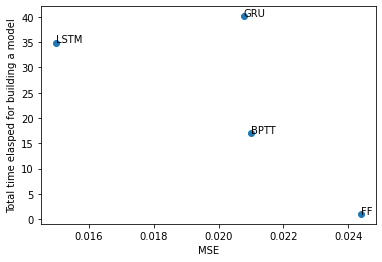

In [64]:
#Scatterplot for total time taken by models and their respective MSE values 
y = [sum(time_ff), sum(time_lstm), sum(time_rnn), sum(time_gru)]
z = [val_ff[-1], val_mse_lstm[-1], val_mse_rnn[-1], val_mse_gru[-1]]
n = ['FF', 'LSTM', 'BPTT', 'GRU']

fig, ax = plt.subplots()
ax.scatter(z, y)
plt.ylabel('Total time elasped for building a model')
plt.xlabel('MSE')

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

**TOTAL TIME ELAPSED AND PERFORMANCE EVALUATION**

1.   Time: 
For this specific problem time elapsed to build the model is lowest for the FeedForward network followed by the BPTT, LSTM and GRU respectively.

REASON: FeedForward neural network is a very simple architecture and hence it takes relatively less time. The architecture for BPTT, GRU and LSTM is very complex and thus it takes longer to perform the task.

2.   Performance (MSE): 
We can evaluate the performance of the model by comparing the MSE scores of the models. Based on the above plot we can see that the LSTM provides the least MSE values. This is followed by the GRU, then BPTT and Feedforward network.

REASON: LSTM has a complex architecture when compared to other models (GRU, BPTT and Feedforward). Therefore, LSTM is able to identify more complex functions and that can be beneficial to extract more relevant data patterns from the dataset. 


However, the time elapsed and the cost of computation might vary with different problem statement.  
